In [2]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import pickle

In [3]:
X_train1=pd.read_csv('../datasets/X_train1.csv',index_col="Id")
X_test1=pd.read_csv('../datasets/X_test1.csv',index_col="Id")
y_train1= pd.read_pickle('../datasets/y_train1.csv')
y_test1= pd.read_pickle('../datasets/y_test1.csv')

In [4]:
columns = X_train1.columns.to_list()

In [40]:
len(columns)

62

# scaling

In [5]:
ss = StandardScaler()

In [6]:
X_train= ss.fit_transform(X_train1)

In [7]:
X_test= ss.transform(X_test1)

## Model Prep: `logTransformer`

In [8]:
pt_y = PowerTransformer()
pt_y.fit(y_train1.to_frame()) 
y_train_pt= pt_y.transform(y_train1.to_frame())
y_test_pt= pt_y.transform(y_test1.to_frame())


## Model Prep: Instantiate our model

In [9]:
lr = LinearRegression()

In [10]:
lr_lasso = LassoCV(alphas=np.logspace(-3,1,100), cv=5)

In [11]:
lr_ridge =RidgeCV(alphas=np.logspace(1, 4, 100),scoring="r2",cv=5)

## Cross validation

In [12]:
lr.fit(X_train, y_train_pt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
lr.score(X_train, y_train_pt)

0.8733284058839378

In [14]:
lr_lasso_scores = cross_val_score(lr_lasso, X_train, y_train_pt[:, 0], cv=5)
lr_lasso_scores.mean()

0.849711053808124

In [15]:
lr_ridge_scores = cross_val_score(lr_ridge, X_train, y_train_pt, cv=5)
lr_ridge_scores.mean()

0.8485578390674139

## Model Fitting 

In [16]:
lr_ridge=lr_ridge.fit(X_train, y_train_pt)

In [17]:
lr_ridge.score(X_train, y_train_pt)

0.8708840118188018

In [18]:
lr_lasso=lr_lasso.fit(X_train, y_train_pt)

/home/ramin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
lr_lasso.score(X_train, y_train_pt)

0.8700340853896728

## Make prediction

In [20]:
pred_train =lr_lasso.predict(X_train)

In [21]:
pred_test = lr_lasso.predict(X_test)

In [22]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_train = pt_y.inverse_transform(pred_train.reshape(-1,1))

In [23]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_test = pt_y.inverse_transform(pred_test.reshape(-1,1))

In [24]:
def model_score(y_true,y_hat):
    RMSE = round(mean_squared_error(y_true , y_hat)**0.5,2)
    R2 = round(r2_score(y_true,y_hat),3)
    MAE = round(mean_absolute_error(y_true,y_hat),2)
    MedAE = round(median_absolute_error(y_true,y_hat),2)
    print(f'Mean Absolute Error: {MAE}\nMedian Absolute Error: {MedAE}\nRoot Mean Squared Error: {RMSE}\nR2: {R2}')

In [25]:
model_score(y_test1,pred_reversed_test)

Mean Absolute Error: 16908.19
Median Absolute Error: 11092.4
Root Mean Squared Error: 39328.79
R2: 0.596


In [26]:
model_score(y_train1,pred_reversed_train)

Mean Absolute Error: 14340.79
Median Absolute Error: 10029.23
Root Mean Squared Error: 22895.24
R2: 0.848


In [27]:
def mlr_residual_visualizer(y_true, y_hat):
    plt.figure(figsize = (20,10))
    plt.scatter(y_hat,y_true, c = '#7D1B7E');
    plt.plot((0,np.max(y_true)),(0,np.max(y_true)), c = 'red'); # identity line
    plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20);
    plt.xticks(fontsize = 40)
    plt.ylabel("Actual Values: $y$", fontsize = 20);
    plt.title("$\hat{y}$ vs. $y$", fontsize = 40);
    plt.legend(['Actual']);
    plt.yticks(fontsize=15);
    plt.xticks(fontsize=15);

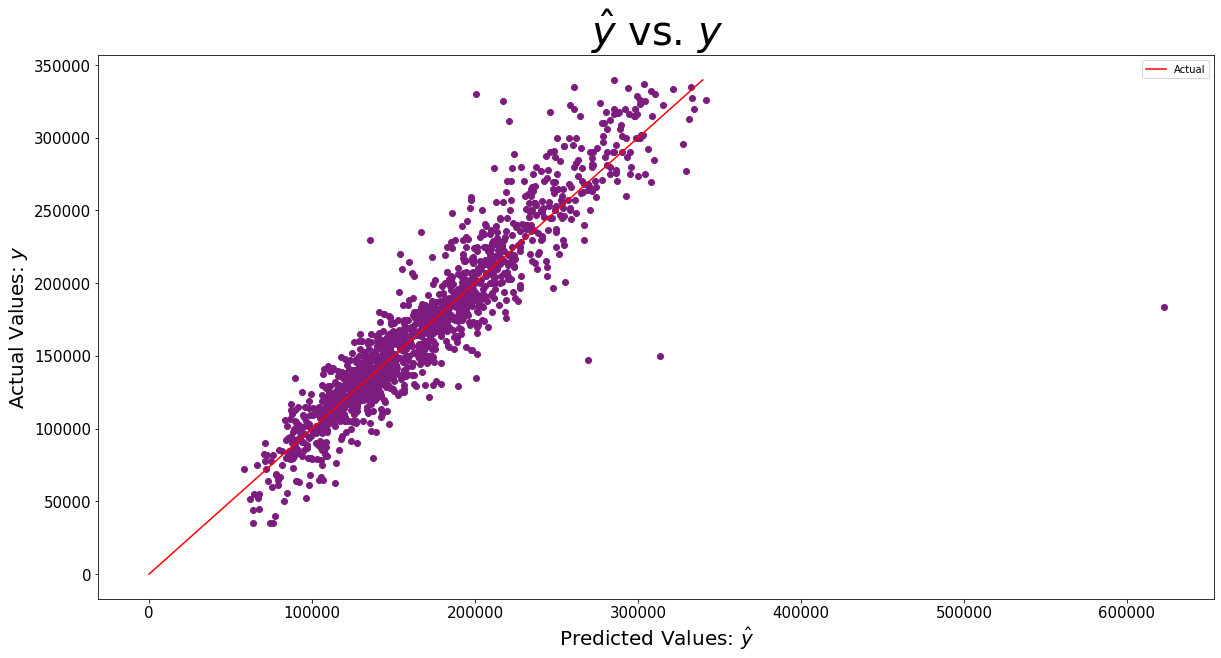

In [28]:
# VISUALIZE FOR YOUR TRAIN
mlr_residual_visualizer(y_train1, pred_reversed_train)
plt.savefig('../plots/train_prediction_basic.png', dpi=235)

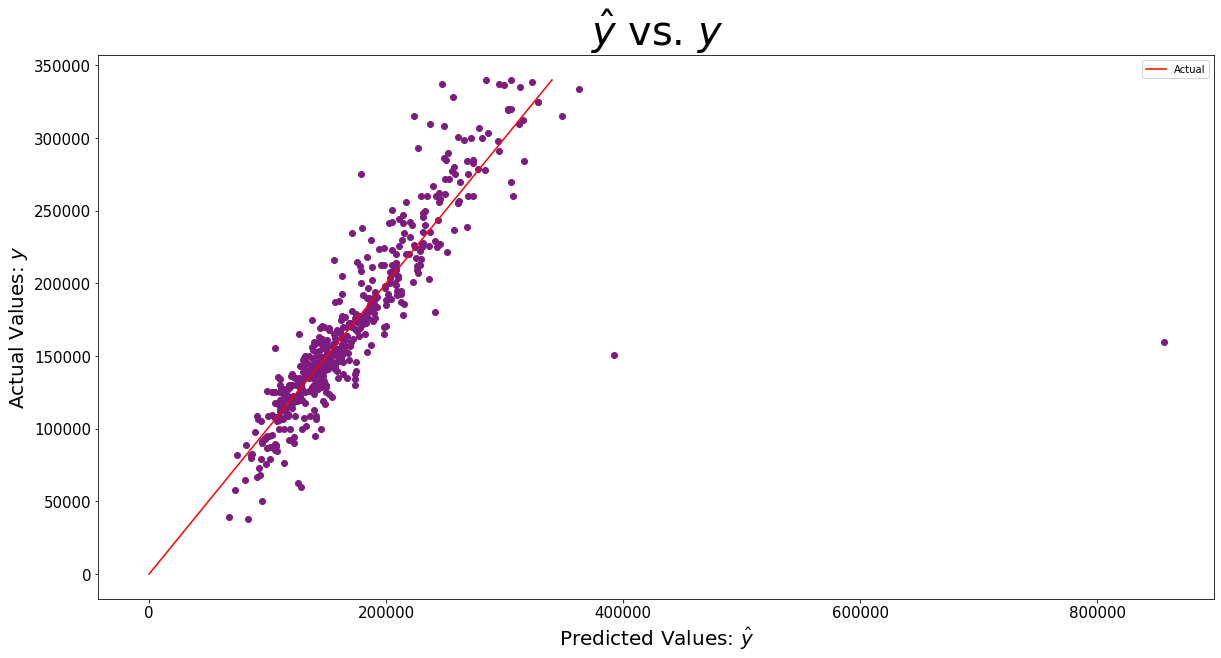

In [29]:
# VISUALIZE FOR YOUR TEST
mlr_residual_visualizer(y_test1,pred_reversed_test)
plt.savefig('../plots/test_prediction_basic.png', dpi=235)

## Create a bar plot of the top 10 coefficients by absolute value of their weights

In [30]:
beta_0 = lr_ridge.intercept_

In [41]:
lr_ridge.coef_.shape=(1,len(columns))

In [42]:
betas = pd.DataFrame(lr_ridge.coef_,columns=columns).T

In [43]:
betas.columns = ['weights']

In [44]:
betas['abs_w'] = betas.weights.abs()

In [45]:
weights = betas.sort_values('abs_w', ascending=False)['weights'].head(15)

In [46]:
labels = weights.index

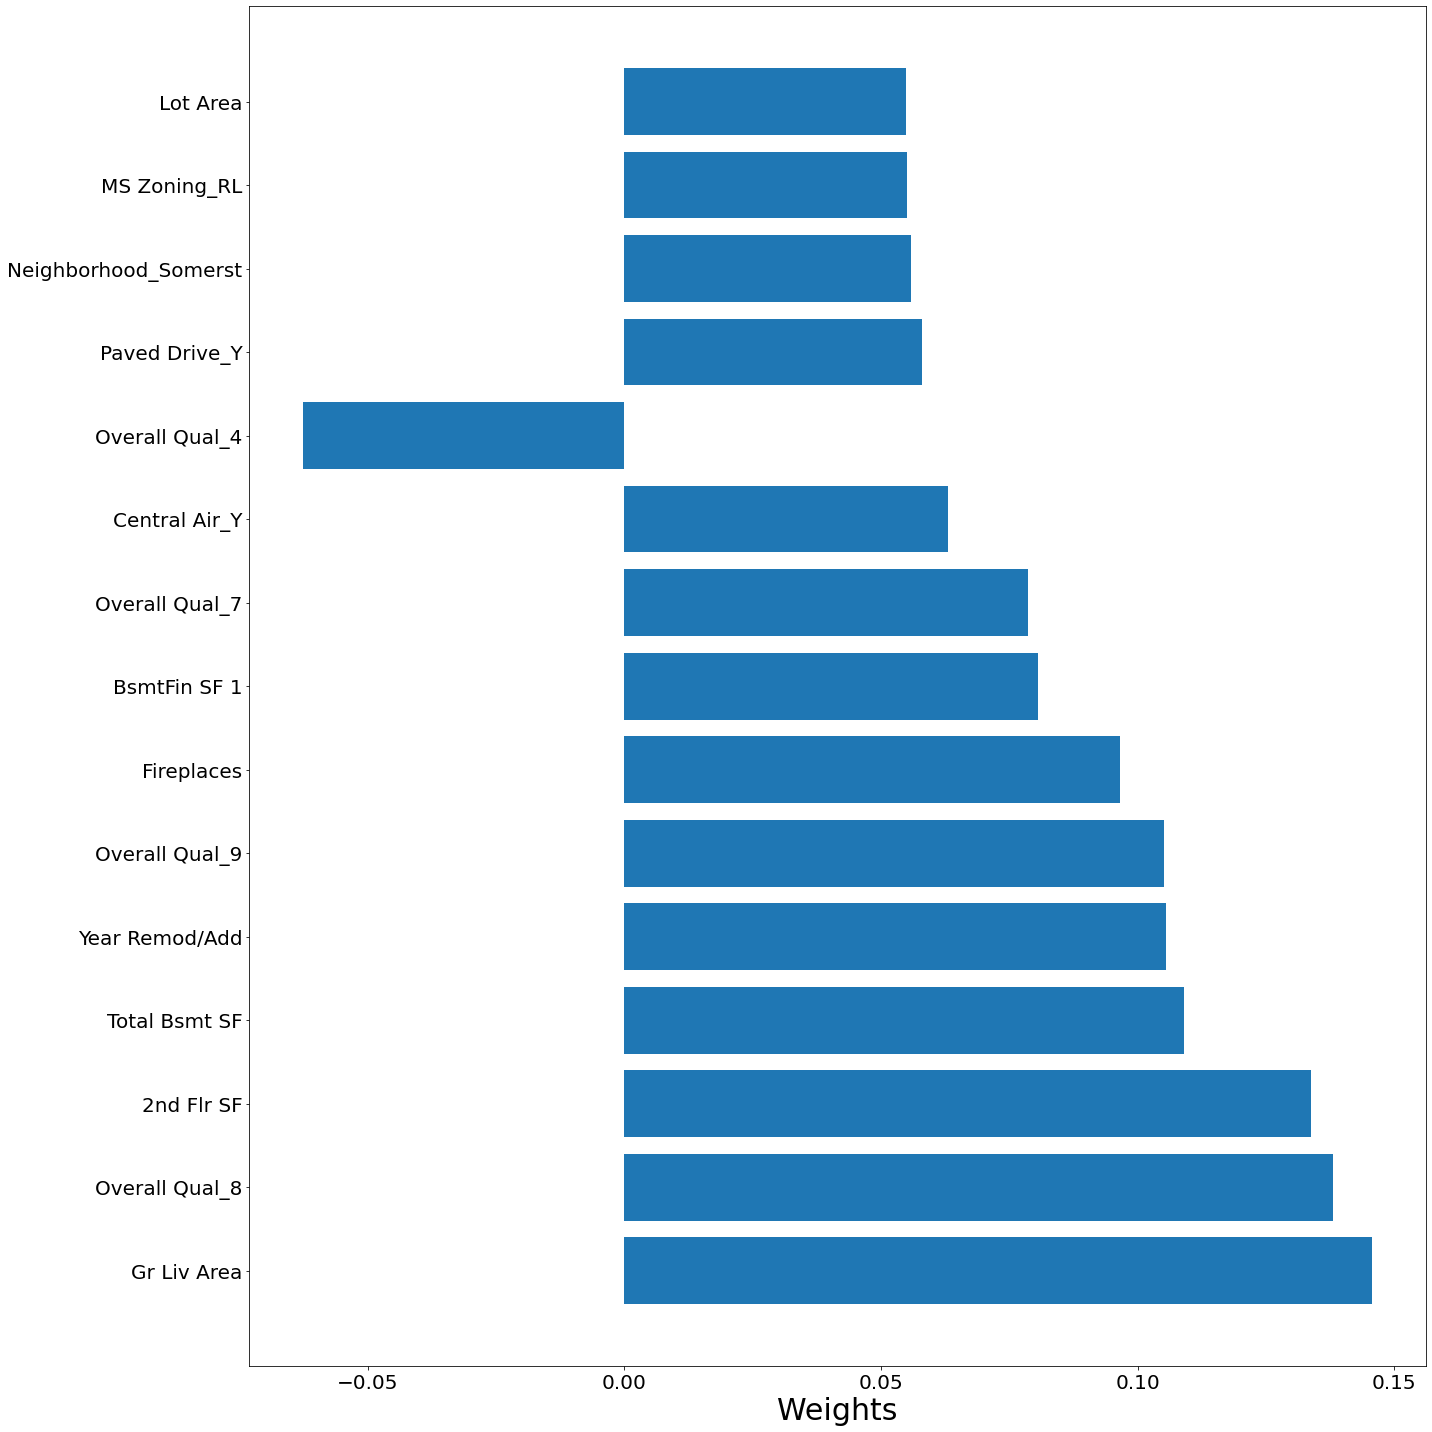

In [47]:
plt.figure(figsize=(20,20))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
#plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()
plt.savefig('../plots/coefficient_basic.png', dpi=235)